In [1]:
import numpy as np
import pandas as pd
import data_process as dp
import matplotlib.pyplot as plt
import DLEDMD
import MLP
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
# load data
sTrain=np.load('./tem_data/v3/sTrain.npy',allow_pickle=True)
cTrain=np.load('./tem_data/v3/cTrain.npy',allow_pickle=True)
iTrain=np.load('./tem_data/v3/iTrain.npy',allow_pickle=True)
oTrain=np.load('./tem_data/v3/oTrain.npy',allow_pickle=True)
oTrain_out=np.load('./tem_data/v3/oTrain_out.npy',allow_pickle=True)

sVal=np.load('./tem_data/v3/sVal.npy',allow_pickle=True)
cVal=np.load('./tem_data/v3/cVal.npy',allow_pickle=True)
iVal=np.load('./tem_data/v3/iVal.npy',allow_pickle=True)
oVal=np.load('./tem_data/v3/oVal.npy',allow_pickle=True)
oVal_out=np.load('./tem_data/v3/oVal_out.npy',allow_pickle=True)

sTest=np.load('./tem_data/v3/sTest.npy',allow_pickle=True)
cTest=np.load('./tem_data/v3/cTest.npy',allow_pickle=True)
iTest=np.load('./tem_data/v3/iTest.npy',allow_pickle=True)
oTest=np.load('./tem_data/v3/oTest.npy',allow_pickle=True)
oTest_out=np.load('./tem_data/v3/oTest_out.npy',allow_pickle=True)

In [3]:
HRT=84 # time=7 hour, equal to 84 steps
outstep=6 # predict 30 min, equal to 6 steps
n=sTest.shape[0]

In [4]:
params = {
            's_input_shape': sTrain.shape[1], 
            'c_input_shape': cTrain.shape[1], 
            'i_input_shape': iTrain.shape[1],
            'o_input_shape': oTrain.shape[1],
            'snet_layer': 3,
            's_net': [{'num': 50}, {'num': 50}, {'num': 50}],
            'cnet_layer': 3,
            'c_net': [{'num': 50}, {'num': 50}, {'num': 50}],
            'inet_layer': 3,
            'i_net': [{'num': 50}, {'num': 50},  {'num': 50}],
            'Encoding_layer': 4,
            'Encoding_param': [{'num': 50} for _ in range(4)],
            'Output_layer': 3,
            'Output_param': [{'num': 50} for _ in range(2)] + [{'num': oTrain_out.shape[1]}],
            'training_data_num': n-outstep-HRT-10
        }

In [13]:
mmd='MLP_net'
inlr=1e-4
model=MLP.MLP_net(params)
model.build_net(inlr)

e:\anaconda3\envs\tensorflow-cpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 s_input (InputLayer)           [(None, 588)]        0           []                               
                                                                                                  
 c_input (InputLayer)           [(None, 252)]        0           []                               
                                                                                                  
 snet_0 (Dense)                 (None, 50)           29450       ['s_input[0][0]']                
                                                                                                  
 cnet_0 (Dense)                 (None, 50)           12650       ['c_input[0][0]']                
                                                                                              

In [14]:
step=1
r,valr=[],[]
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1)
for ep in range(500):
    hist=model.model.fit(x=[sTrain,cTrain,iTrain,oTrain], y=[oTrain_out],epochs=step,verbose=0,callbacks=[reduce_lr])
    y=model.model.predict([sVal,cVal,iVal,oVal])
    r.append(hist.history['loss'][-1])
    valr.append(np.sqrt(np.mean(np.square(y-oVal_out))))
    if np.mod(ep,50)==0:
        model.model.save('./Results/' + mmd + '/model/v3/model_v3_'+str(ep)+'.h5')
        np.save('./Results/' + mmd + '/model/v3/model_train_r1.npy', r)
        np.save('./Results/' + mmd + '/model/v3/model_train_val1.npy', valr)
    print('Epoch:',ep,' | ','training error:',r[-1],' | ','val error:',valr[-1])

e:\anaconda3\envs\tensorflow-cpu\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Epoch: 0  |  training error: 0.14946175372679063  |  val error: 0.26213885347832555
Epoch: 1  |  training error: 0.05671313181972431  |  val error: 0.2125631138442818
Epoch: 2  |  training error: 0.041187297605665016  |  val error: 0.1886503984629934
Epoch: 3  |  training error: 0.034035528244746975  |  val error: 0.1773983103131833
Epoch: 4  |  training error: 0.030039911891551727  |  val error: 0.16911101166778333
Epoch: 5  |  training error: 0.026934839284996737  |  val error: 0.1625473564562611
Epoch: 6  |  training error: 0.02454918355368674  |  val error: 0.15696649242984712
Epoch: 7  |  training error: 0.02251560144926579  |  val error: 0.15039988708345403
Epoch: 8  |  training error: 0.020495262523507276  |  val error: 0.14605909970395028
Epoch: 9  |  training error: 0.019229471553286883  |  val error: 0.14532950904506622
Epoch: 10  |  training error: 0.018347944645352637  |  val error: 0.14348438387992862
Epoch: 11  |  training error: 0.016466143530658554  |  val error: 0.1362

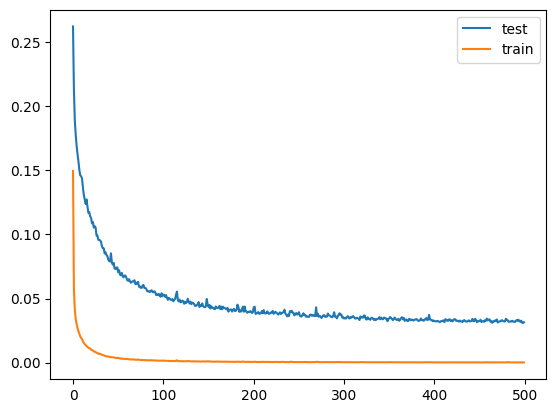

In [15]:
plt.figure()
plt.plot(valr,label='test')
plt.plot(r,label='train')
plt.legend()
plt.savefig('./Results/' + mmd + '/model/v3/train_error_1.tif')

# Model Prediction

In [16]:
Y=model.model.predict([sTest,cTest,iTest,oTest])
print(np.sqrt(np.mean(np.square(Y-oTest_out))))
np.save('./Results/'+mmd+'/predict/v3/prediction.npy',Y)

0.02786479509731473


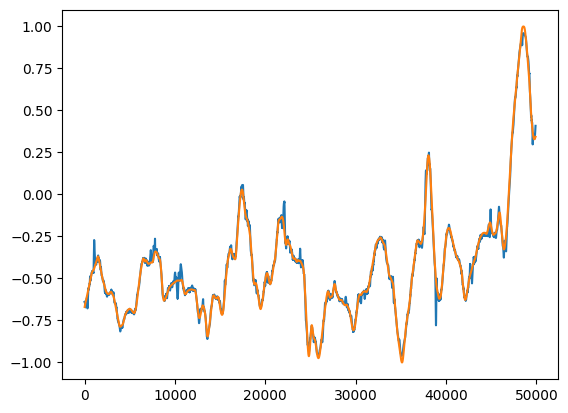

In [17]:
i=1
plt.plot(Y[:,i])
plt.plot(oTest_out[:,i])